# Network Analysis Comparison between OSM and PyPSA Eur Data

This jupyter notebook explores a comparison between the OSM and PyPSA Eur data.

To run this notebook successfully, `osm_data` and `pypsa_eur_data` will need to be downloaded. The file size for `osm_data` and `pypsa_eur_data` are 3GB and 500MB respectively.
The files are currently stored in a google drive. You can download the files using their respective IDs.

drive link for osm_data: https://drive.google.com/file/d/1AuUnJHO8ODyWsQBbdDyq8Bktw78W0219/view?usp=drive_link

id for osm_data: 1AuUnJHO8ODyWsQBbdDyq8Bktw78W0219

drive link for pypsa_eur data: https://drive.google.com/file/d/1EKuKtqQkewwPXyZDh9zgKwsfmwODCQEV/view?usp=drive_link

id for pypsa_eur-Eur data: 1EKuKtqQkewwPXyZDh9zgKwsfmwODCQEV

## Download files

If you have the data already, you can skip this section.

In [1]:
# installing gdown. gdown is a python library that will be used to download the files from google drive using the ID
!pip install gdown -qq


In [2]:
# download osm_data
!gdown "1AuUnJHO8ODyWsQBbdDyq8Bktw78W0219" -O elec-osm.nc

# download pypsa_eur_data
!gdown "1EKuKtqQkewwPXyZDh9zgKwsfmwODCQEV" -0 elec-entsoe.nc

## Network Analysis

In [3]:
# loading required libraries
import pypsa
import geopy
import matplotlib.pyplot as plt
import time

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 1000)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
# loading the data into variables
entsoe = pypsa.Network("elec-entsoe.nc")
osm = pypsa.Network("elec-osm.nc")


INFO:pypsa.io:Imported network elec-entsoe.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers
INFO:pypsa.io:Imported network elec-osm.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers


### Intercomparison by data source

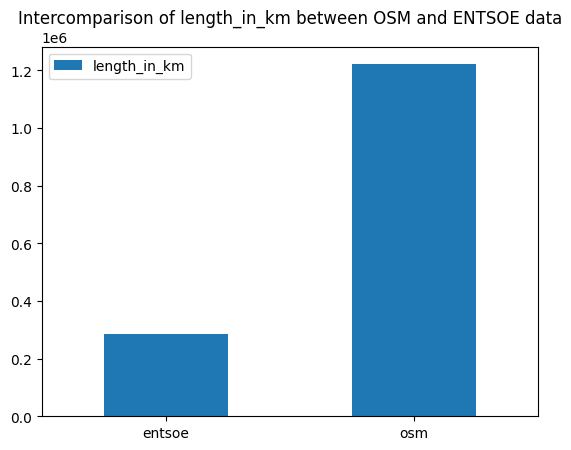

In [5]:
# calculate length_in_km for volatage greater than 220kV and only AC lines for both the OSM data and PyPSA-Eur data

# filter for voltage greater than 220kV for entsoe data
entose_220 = entsoe.lines[entsoe.lines.v_nom >= 220.0]

# sum of length and num_parallel on the filtered data
entsoe_length_in_km = sum(entose_220['length'] * entose_220['num_parallel'])

# filter for voltage greater than 220kV and AC lines only for osm data
osm_220 = osm.lines[(osm.lines.v_nom >= 220.0) & (osm.lines.dc == False)]

# sum of length and num parellel on the filtered data
osm_length_in_km = sum(osm_220['length'] * osm_220['num_parallel'])

# dataframe to store the
df = pd.DataFrame(
    {'columns': ['entsoe', 'osm'],
     'length_in_km': [entsoe_length_in_km, osm_length_in_km]
     })

# plot the dataframe data
ax = df.plot.bar(
    x='columns',
    y='length_in_km',
    rot=0,
    xlabel='',
    title="Intercomparison of length_in_km between OSM and ENTSOE data"
)


### Intercomparison by country

In [6]:
# calculate length_in_km volatage greater than 220kV and only AC lines for both the OSM data and PyPSA-Eur data to get a country comparison plot
# the entsoe.line data does not have a country columns. inorder to get the countries, entsoe.line is merged with entsoe.buses on bus column.

# length * num_parallel on the osm data
osm_220['length_in_km'] = (osm_220['length'] * osm_220['num_parallel'])

# sum of length in osm data grouped by country
osm_country_stats_length_in_km = osm_220[['country', 'length_in_km']].groupby(
    ['country'])[['length_in_km']].sum()  

# merge entsoe.lines and entsoe.buses to get country of each lines
entsoe_merged = entsoe.lines.merge(
    entsoe.buses['country'].reset_index(), how='left', left_on='bus0', right_on='Bus')  

# length * num_parallel on the merged entsoe data
entsoe_merged['length_in_km'] = (
    entsoe_merged['length'] * entsoe_merged['num_parallel'])  

# sum of length in entsoe data grouped by country
entsoe_merged_country_stats_length_in_km = entsoe_merged[(entsoe_merged.v_nom >= 220.0)][[
    'country', 'length_in_km']].groupby(['country'])[['length_in_km']].sum()  

# resetting the index for the grouped entsoe data
entsoe_merged_country_stats_length_in_km.reset_index(
    inplace=True)  
    
# resetting the index for the grouped osm data
osm_country_stats_length_in_km.reset_index(inplace=True)


In [7]:
# checking to see the country available in OSM data that is not in PyPSA-Eur data using a dictionary structure

osm_dict = osm_country_stats_length_in_km['country'].to_dict()
entsoe_dict = entsoe_merged_country_stats_length_in_km['country'].to_dict()

# for loop to check present values in osm data that is not in entsoe data
for idx in osm_dict.values():
    if idx not in entsoe_dict.values():
        print(idx)


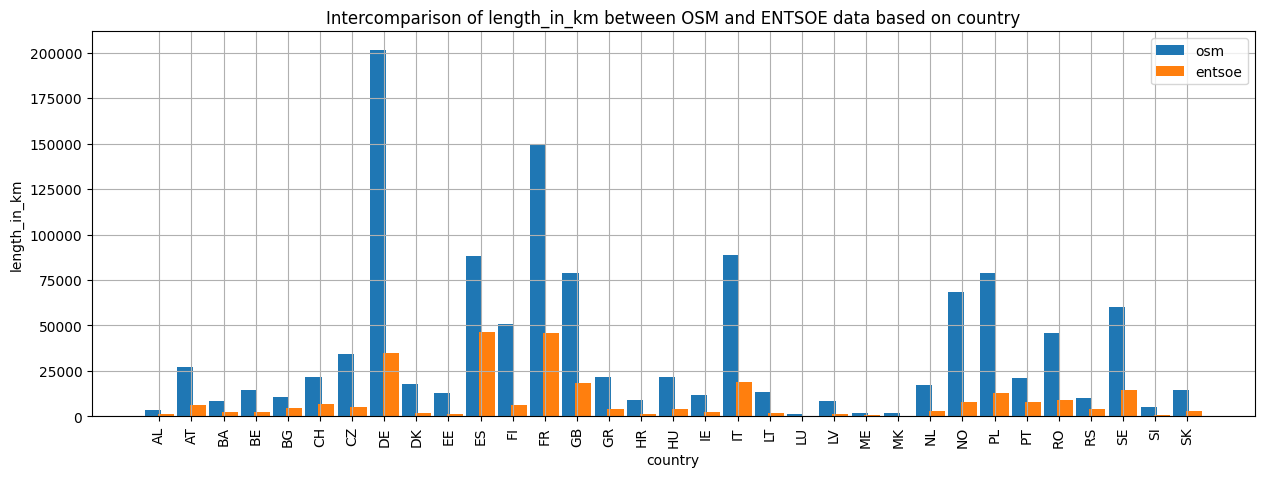

In [8]:
#define figure size
plt.figure(figsize=(15, 5))

# convert data to numpy array to fit in the x-axis
entsoe_x_axis = np.arange(
    len(entsoe_merged_country_stats_length_in_km['country']))
osm_x_axis = np.arange(len(osm_country_stats_length_in_km['country']))

# plot a barchart
plt.bar(osm_x_axis - 0.2,
        osm_country_stats_length_in_km['length_in_km'], 0.5, label='osm')
plt.bar(entsoe_x_axis + 0.2,
        entsoe_merged_country_stats_length_in_km['length_in_km'], 0.5, label='entsoe')

plt.xticks(entsoe_x_axis, entsoe_merged_country_stats_length_in_km['country'])
plt.xticks(rotation=90)
plt.title(
    'Intercomparison of length_in_km between OSM and ENTSOE data based on country')
plt.xlabel('country')
plt.ylabel('length_in_km')
plt.grid(True)
plt.legend()
plt.show()


### Intercomparison by voltage levels

In [9]:
# grouping the OSM-data and PyPSA-Eur data by length to plot total length by voltage levels

# sum of length grouped entsoe data by voltage level
osm_voltage_stats_length = osm.lines[[
    'v_nom', 'length']][osm.lines.dc == False].groupby(['v_nom'])[['length']].sum()

# resetting index
osm_voltage_stats_length.reset_index(inplace=True)

# sum of length grouped entsoe data by voltage level
entsoe_voltage_stats_length = entsoe.lines[['v_nom', 'length']].groupby(['v_nom'])[
    ['length']].sum()

# resetting index
entsoe_voltage_stats_length.reset_index(inplace=True)


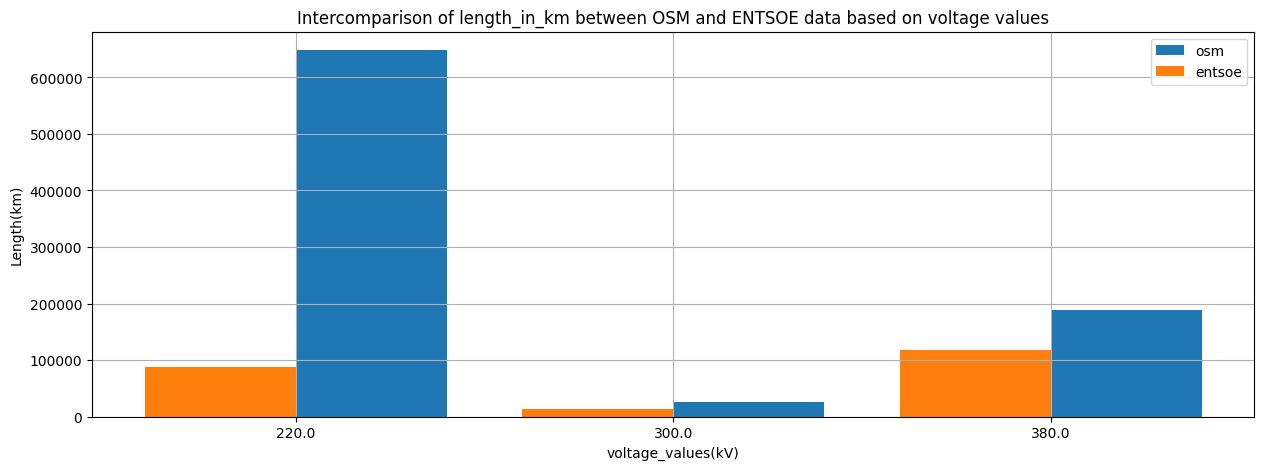

In [10]:
#define figure size
plt.figure(figsize=(15, 5))

# convert data to numpy array to fit in the x-axis
entsoe_x_axis = np.arange(len(entsoe_voltage_stats_length['v_nom']))
osm_x_axis = np.arange(len(osm_voltage_stats_length['v_nom']))

# plot data using a barchart
plt.bar(osm_x_axis + 0.2, osm_voltage_stats_length.length, 0.4, label='osm')
plt.bar(entsoe_x_axis - 0.2, entsoe_voltage_stats_length.length, 0.4, label='entsoe')

plt.xticks(osm_x_axis, osm_voltage_stats_length['v_nom'])
plt.xticks(rotation=0)
plt.title('Intercomparison of length_in_km between OSM and ENTSOE data based on voltage values')
plt.xlabel('voltage_values(kV)')
plt.ylabel('Length(km)')
plt.grid('True')
plt.legend()
plt.show()
